F1 Score (Validation Set): 0.8928270042194092
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1830
           1       0.90      0.88      0.89      1798

    accuracy                           0.89      3628
   macro avg       0.90      0.89      0.89      3628
weighted avg       0.90      0.89      0.89      3628



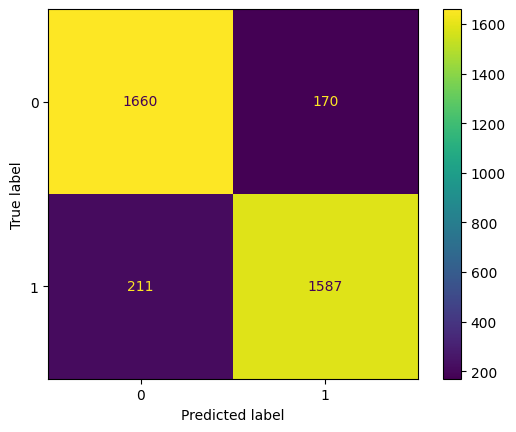

Submission file created: 'submission.csv'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
from scipy.stats import randint, uniform

warnings.filterwarnings("ignore")
%matplotlib inline

# Baca data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Preprocessing
train.columns = train.columns.str.strip().str.replace(' ', '')
train["income"] = train["income"].str.strip()
test.columns = test.columns.str.strip().str.replace(' ', '')

train = train.replace('?', np.nan)
test = test.replace('?', np.nan)
train.dropna(inplace=True)

cat_columns = ['KelasPekerjaan', 'Pendidikan', 'JenjangPendidikan', 'Status', 'Pekerjaan', 'Hubungan', 'Etnis', 'sex', 'AsalNegara']
df_dumy_train = pd.get_dummies(train, columns=cat_columns)
df_dumy_test = pd.get_dummies(test, columns=cat_columns)

df_dumy_test = df_dumy_test.reindex(columns=df_dumy_train.columns, fill_value=0)

X = df_dumy_train.drop("income", axis=1)
y = df_dumy_train["income"].apply(lambda x: 1 if x == '>50K' else 0)

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Membagi data
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.1, random_state=101)

# Scaling fitur
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(df_dumy_test.drop("income", axis=1, errors='ignore'))

# Tuning Hyperparameter dengan RandomizedSearchCV untuk RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search_rf.fit(scaled_X_train, y_train)
best_rf = random_search_rf.best_estimator_

# Evaluasi performa model pada validation set
val_predictions = best_rf.predict(scaled_X_val)
print("F1 Score (Validation Set):", f1_score(y_val, val_predictions))
print(classification_report(y_val, val_predictions))

ConfusionMatrixDisplay.from_estimator(best_rf, scaled_X_val, y_val)
plt.show()

# Prediksi pada data test
test_predictions = best_rf.predict(scaled_X_test)

# Buat DataFrame untuk submission
submission = pd.DataFrame({
    'ID': test['ID'],
    'income': ['1' if pred == 1 else 0 for pred in test_predictions]
})

submission['income'] = submission['income'].fillna('')
submission.to_csv('submission.csv', index=False)
print("Submission file created: 'submission.csv'")
